# Report Basics of Mobile Robotics

Report of Jean, Vadim, Sara and Lisa.

**Table of Contents:**
1. [Introduction](#Introduction)
2. [Vision](#Vision)
3. [Global Path Planning](#Global-Path-Planning)
4. [Localization with Kalman Filter](#Kalman-Filter)
5. [Motor Control](#Motor-Control)
6. [Local Obstacle Avoidance](#Local-Obstacle-Avoidance)
7. [Putting it all together](#Putting-it-all-together)
8. [Conclusion](#Conclusion)

## Introduction

<span style="color:red">
Describe our general project idea. Introduction to the environement and choices we made. General function of the main components.

Structure of the code
</span>

## Vision

<span style="color:red">
Code required to execute vision module independently. Don't describe the code but explain what is behind it (i.e. theory, algorithms, measurements, choice of parameters, etc.).

CITE YOUR SOURCES
</span>



Let's start by defining what main functionalities the vision module should accomplish.
1. Find the **borders of the map** in the image.
2. Detect the **global obstacles**, which are placed on the map.
3. Locate the **position of the robot** in the map.
4. Locate the **position of the goal** in the map.

As our camera has fixed position points 1,2 and 4 only need to be done once during the initalization of the map, while the localization of the robot will be used during runtime as a measurement for the Kalman filter.

Additionally a visualition during runtime of all the above points, as well as the estimated robot position given by the filter and the planned path will ease the development further.

### Borders of the map

To find the borders of the map, we decided to use [aruco markers](https://www.uco.es/investiga/grupos/ava/portfolio/aruco/l) - a robust library available for open cv to detect predefined markers in an image used for pose estimation - to mark the corners of our map.

For this we find the first corner of each four corner markers (markers have ids 1-4). We then apply a perspective transform where we map the four given corners to predefined image of size 350x240 pixel. The choice of the cropped map size is based on the actual size of our image, which is 1050mmx720mm, so every pixel in our cropped map corresponds to 3 mm in reality.

This whole step is done in the camera class in `src/vision/camera.py`, for illustration purposes the important code will be copied here.

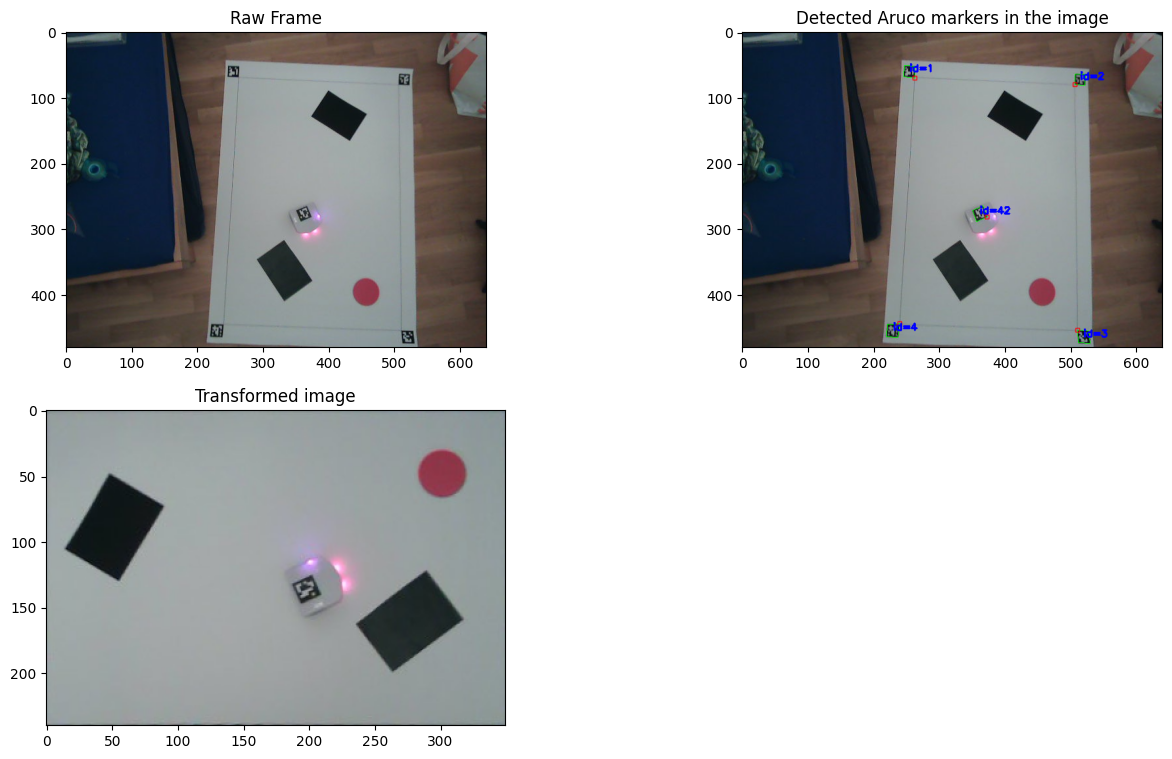

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from src.vision.helpers import get_corner, perspective_transform, Hyperparameters, read_yaml

example_img_path = "media/example_map.jpg"
frame = cv2.imread(example_img_path)
global_corners = [None, None, None, None]
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
aruco_detector = cv2.aruco.ArucoDetector(aruco_dict, cv2.aruco.DetectorParameters())
hyperparams = Hyperparameters(read_yaml())

# This function is taken from src/vision/camera.py and modified to make it work without
# the class context.
def _find_corners(frame, aruco_detecter, show=False):
    """
    Detects the aruco markers of the corners and updates the position

    Args:
        show (bool): If True shows the frame with drawn markers. Default: False
    """
    if show:
        img = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, rejected = aruco_detector.detectMarkers(gray)
    if ids is not None:
        # the 4 corner of our map have ids 1,2,3,4
        for i, id in enumerate(ids):
            if id >= 1 and id <= 4:  # only consider corner markers
                global_corners[id[0]-1] = get_corner(corners[i])
        if show:
            cv2.aruco.drawDetectedMarkers(img, corners, ids)
    
    if show:
        return img

plt.figure(figsize=(16,9))
plt.subplot(221)
plt.title("Raw Frame")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.title("Detected Aruco markers in the image")
markers = _find_corners(frame, aruco_detector, show=True)
plt.imshow(cv2.cvtColor(markers, cv2.COLOR_BGR2RGB))
plt.subplot(223)
plt.title("Transformed image")
warped = perspective_transform(frame, global_corners, hyperparams.map_size[0], hyperparams.map_size[1])
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

### Global obstacles

The global (black) obstacles are extracted from the image by:
- thresholding the image to extract the black pixels
- using a canny edge detector to find the edges
- finding the contours and filtering them by area


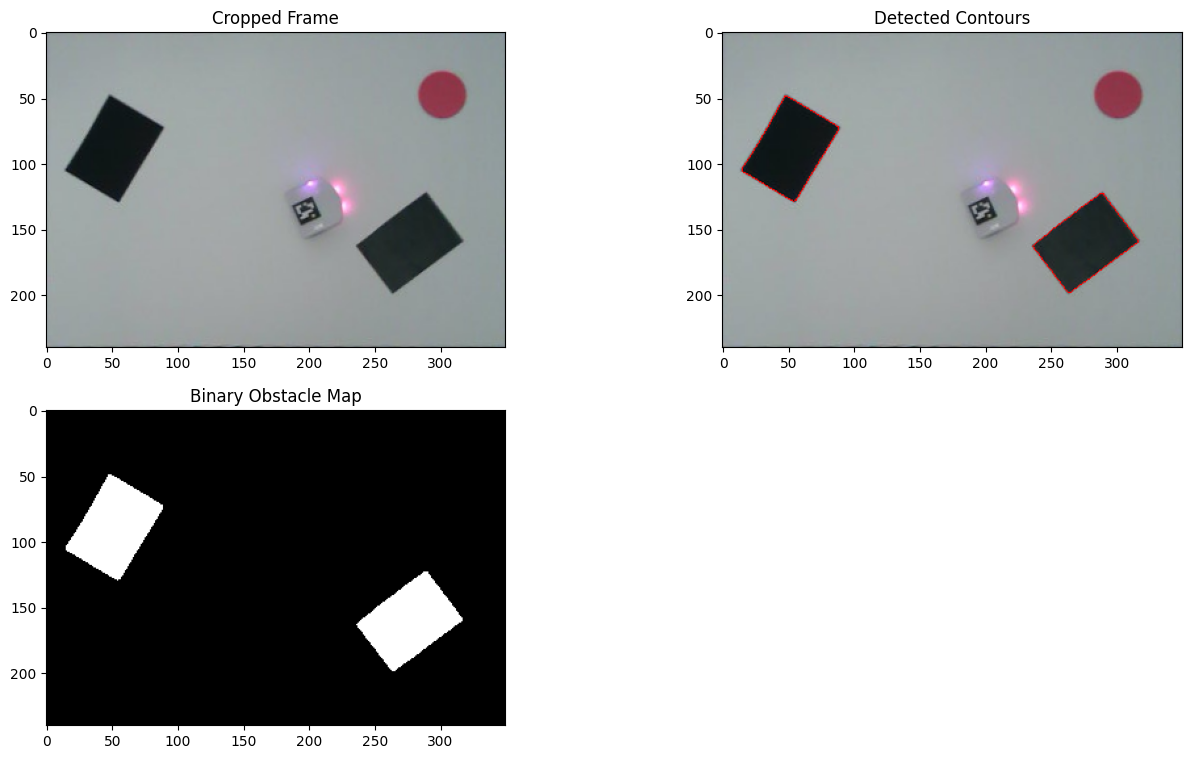

In [19]:
def _extract_obstacles(cropped_img, hyperparams: Hyperparameters, show_warped: bool = False):
    """
    Thresholds the current frame to see the black obstacles.

    Args:
        show_warped (bool): If True shows the cropped image with drawn contours. 
                            Default: False.
    """
    warped = cropped_img.copy()
    thresholded = cv2.inRange(warped, (0, 0, 0), 
                                (hyperparams.obstacles.blue, 
                                hyperparams.obstacles.green,
                                hyperparams.obstacles.red))
    
    canny = cv2.Canny(thresholded, 94, 98, apertureSize=3)
    kernel = np.ones((hyperparams.obstacles.kernel_size, 
                      hyperparams.obstacles.kernel_size), np.uint8)
    morph = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filter controus where area < 1000
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > hyperparams.obstacles.area]
    map = np.zeros_like(warped, dtype=np.uint8)
    
    cv2.drawContours(map, contours, -1, (255, 255, 255), cv2.FILLED)
    if show_warped:
        cv2.drawContours(warped, contours, -1, (0, 0, 255), 1)
        # cv2.imshow('warped', warped)
        return warped, map
    return map

plt.figure(figsize=(16,9))
plt.subplot(221)
plt.title("Cropped Frame")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.title("Detected Contours")
contours, map = _extract_obstacles(warped, hyperparams, show_warped=True)
plt.imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
plt.subplot(223)
plt.title("Binary Obstacle Map")
plt.imshow(cv2.cvtColor(map, cv2.COLOR_BGR2RGB))
plt.show()

## Global Path Planning

<span style="color:red">
Code required to execute vision module independently. Don't describe the code but explain what is behind it (i.e. theory, algorithms, measurements, choice of parameters, etc.).

CITE YOUR SOURCES
</span>

## Kalman Filter

<span style="color:red">
Code required to execute vision module independently. Don't describe the code but explain what is behind it (i.e. theory, algorithms, measurements, choice of parameters, etc.).

CITE YOUR SOURCES
</span>

## Motor Control

<span style="color:red">
Code required to execute vision module independently. Don't describe the code but explain what is behind it (i.e. theory, algorithms, measurements, choice of parameters, etc.).

CITE YOUR SOURCES
</span>

## Local Obstacle Avoidance

<span style="color:red">
Code required to execute vision module independently. Don't describe the code but explain what is behind it (i.e. theory, algorithms, measurements, choice of parameters, etc.).

CITE YOUR SOURCES
</span>

## Putting it all together

<span style="color:red">
A section which is used to run the overall project and where we can see the path chosen, where the system believes the robot is along the path before and after filtering etc… 

REFERENCE OT THE MAIN FILE.
</span>

## Conclusion

<span style="color:red">
What we learned, what we would do differently, what we would like to add, etc.
</span>